In [1]:
#Run the following code to print multiple outputs from a cell
get_ipython().ast_node_interactivity = 'all'

## Final Exam Practice: Predicting Potholes

The file, “dataPotholes.csv”, has the following variables:
* Date: Date of the pothole report
* PotholeReports: Number of potholes reported that day
* Temperature: Temperature (in Fahrenheit)
* Humidity: Percent humidity 
* WindSpeed: in meters per second 
* Rainfall: Amount of rain (in millimeters)
* ExpectedWorkload: Management's projection of workload

**Dang! After 2020-05-21, WindSpeed is accidentally in feet/second, not meters/second. Also, workers didn't record Rainfall if there was no rain. You’re also interested in the effect of Weekday and Month.**

Your task:
1. Predict PotholeReports using an econometric & ML model (w/o ExpectedWorkload)
2. Predict ExpectedWorkload using an ML Classifier (w/o PotholeReports)

### Import Data & Profile

In [2]:
import pandas as pd
df = pd.read_csv("dataPotholes.csv")
df
df.dtypes
df.isna().sum()
df.describe()
df["ExpectedWorkload"].value_counts()

,Date,PotholeReports,Temperature,Humidity,WindSpeed,Rainfall,ExpectedWorkload
0,2019-11-21,254,65.2,37,2.200000,NaN,Low
1,2019-11-21,204,65.5,38,0.800000,NaN,Low
2,2019-11-21,173,66.0,39,1.000000,NaN,Low
3,2019-11-21,107,66.2,40,0.900000,NaN,Low
4,2019-11-21,78,66.0,36,2.300000,NaN,Low
...,...,...,...,...,...,...,...
8755,2020-11-19,1003,55.8,34,8.530184,NaN,Low
8756,2020-11-19,764,56.6,37,7.545932,NaN,Low
8757,2020-11-19,694,57.4,39,0.984252,NaN,Low
8758,2020-11-19,712,57.9,41,3.280840,NaN,Low


Date                 object
PotholeReports        int64
Temperature         float64
Humidity              int64
WindSpeed           float64
Rainfall            float64
ExpectedWorkload     object
dtype: object

Date                   0
PotholeReports         0
Temperature            0
Humidity               0
WindSpeed              0
Rainfall            8232
ExpectedWorkload       0
dtype: int64

,PotholeReports,Temperature,Humidity,WindSpeed,Rainfall
count,8760.000000,8760.000000,8760.000000,8760.000000,528.000000
mean,704.602055,47.117078,58.226256,3.487925,2.466856
std,644.997468,11.944825,20.362413,2.775663,3.927524
min,0.000000,20.600000,0.000000,0.000000,0.100000
25%,191.000000,37.500000,42.000000,1.400000,0.500000
50%,504.500000,46.300000,57.000000,2.700000,1.000000
75%,1065.250000,56.500000,74.000000,4.593176,2.500000
max,3556.000000,77.800000,98.000000,22.637796,35.000000


Low       6719
Medium    1773
High       268
Name: ExpectedWorkload, dtype: int64

array([[<AxesSubplot: xlabel='PotholeReports', ylabel='PotholeReports'>,
        <AxesSubplot: xlabel='Temperature', ylabel='PotholeReports'>,
        <AxesSubplot: xlabel='Humidity', ylabel='PotholeReports'>,
        <AxesSubplot: xlabel='WindSpeed', ylabel='PotholeReports'>,
        <AxesSubplot: xlabel='Rainfall', ylabel='PotholeReports'>],
       [<AxesSubplot: xlabel='PotholeReports', ylabel='Temperature'>,
        <AxesSubplot: xlabel='Temperature', ylabel='Temperature'>,
        <AxesSubplot: xlabel='Humidity', ylabel='Temperature'>,
        <AxesSubplot: xlabel='WindSpeed', ylabel='Temperature'>,
        <AxesSubplot: xlabel='Rainfall', ylabel='Temperature'>],
       [<AxesSubplot: xlabel='PotholeReports', ylabel='Humidity'>,
        <AxesSubplot: xlabel='Temperature', ylabel='Humidity'>,
        <AxesSubplot: xlabel='Humidity', ylabel='Humidity'>,
        <AxesSubplot: xlabel='WindSpeed', ylabel='Humidity'>,
        <AxesSubplot: xlabel='Rainfall', ylabel='Humidity'>],
       

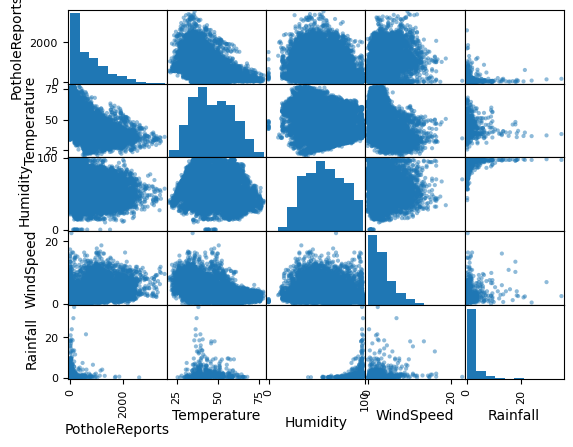

In [3]:
pd.plotting.scatter_matrix(df)

<AxesSubplot: >

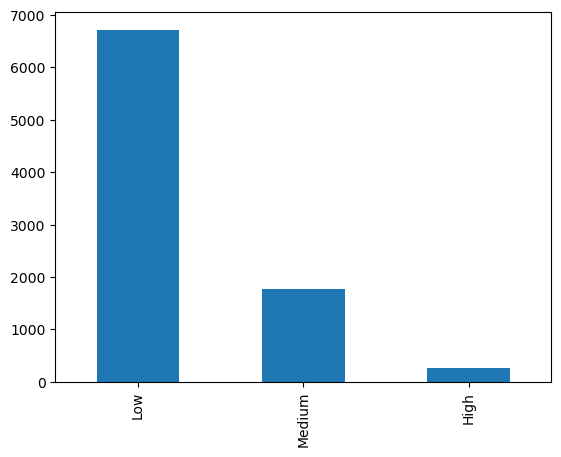

In [4]:
df["ExpectedWorkload"].value_counts().plot.bar()

### Feature Engineering

In [5]:
df["Rainfall2"] = df["Rainfall"]
df.loc[pd.isna(df["Rainfall2"]), "Rainfall2"] = 0
df.isna().sum()

Date                   0
PotholeReports         0
Temperature            0
Humidity               0
WindSpeed              0
Rainfall            8232
ExpectedWorkload       0
Rainfall2              0
dtype: int64

In [6]:
# To convert feet to meters, you multiply feet * 0.3
df["WindSpeed2"] = df["WindSpeed"]
df.loc[df["Date"] > "2020-05-21", "WindSpeed2"] = df["WindSpeed2"] * 0.3
df.describe()

,PotholeReports,Temperature,Humidity,WindSpeed,Rainfall,Rainfall2,WindSpeed2
count,8760.000000,8760.000000,8760.000000,8760.000000,528.000000,8760.000000,8760.000000
mean,704.602055,47.117078,58.226256,3.487925,2.466856,0.148687,1.712736
std,644.997468,11.944825,20.362413,2.775663,3.927524,1.128193,1.032053
min,0.000000,20.600000,0.000000,0.000000,0.100000,0.000000,0.000000
25%,191.000000,37.500000,42.000000,1.400000,0.500000,0.000000,0.900000
50%,504.500000,46.300000,57.000000,2.700000,1.000000,0.000000,1.500000
75%,1065.250000,56.500000,74.000000,4.593176,2.500000,0.000000,2.300000
max,3556.000000,77.800000,98.000000,22.637796,35.000000,35.000000,7.400000


In [7]:
df["Weekday"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d").dt.day_name()
df["Month"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d").dt.month_name()
df

,Date,PotholeReports,Temperature,Humidity,WindSpeed,Rainfall,ExpectedWorkload,Rainfall2,WindSpeed2,Weekday,Month
0,2019-11-21,254,65.2,37,2.200000,NaN,Low,0.0,2.200000,Thursday,November
1,2019-11-21,204,65.5,38,0.800000,NaN,Low,0.0,0.800000,Thursday,November
2,2019-11-21,173,66.0,39,1.000000,NaN,Low,0.0,1.000000,Thursday,November
3,2019-11-21,107,66.2,40,0.900000,NaN,Low,0.0,0.900000,Thursday,November
4,2019-11-21,78,66.0,36,2.300000,NaN,Low,0.0,2.300000,Thursday,November
...,...,...,...,...,...,...,...,...,...,...,...
8755,2020-11-19,1003,55.8,34,8.530184,NaN,Low,0.0,2.559055,Thursday,November
8756,2020-11-19,764,56.6,37,7.545932,NaN,Low,0.0,2.263780,Thursday,November
8757,2020-11-19,694,57.4,39,0.984252,NaN,Low,0.0,0.295276,Thursday,November
8758,2020-11-19,712,57.9,41,3.280840,NaN,Low,0.0,0.984252,Thursday,November


### Predicting Pothole Reports

#### Econometric Model

In [8]:
import statsmodels.formula.api as smf
resultOLS = smf.ols("PotholeReports ~ Temperature + Humidity + WindSpeed2 +\
                     Rainfall2 + Weekday + Month", data = df).fit()
print(resultOLS.summary())

                            OLS Regression Results                            
Dep. Variable:         PotholeReports   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     317.8
Date:                Wed, 22 Feb 2023   Prob (F-statistic):               0.00
Time:                        01:53:20   Log-Likelihood:                -66614.
No. Observations:                8760   AIC:                         1.333e+05
Df Residuals:                    8738   BIC:                         1.334e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2730.9711 

#### ML Model

In [9]:
outcome1 = df["PotholeReports"]
numericFeatures = df[["Temperature", "Humidity", "WindSpeed2", "Rainfall2"]]
dummyWeekday = pd.get_dummies(df["Weekday"], prefix = "Weekday", drop_first = True)
dummyMonth = pd.get_dummies(df["Month"], prefix = "Month", drop_first = True)
features = pd.concat([numericFeatures, dummyWeekday, dummyMonth], axis = 1)

In [10]:
from sklearn.model_selection import train_test_split
featuresTrain, featuresTest, outcome1Train, outcome1Test = train_test_split(features, outcome1, test_size = 0.33, random_state = 42)

In [11]:
import sklearn.ensemble
modelForest = sklearn.ensemble.RandomForestRegressor(random_state = 42)
resultForest = modelForest.fit(featuresTrain, outcome1Train)
predForestTrain = modelForest.predict(featuresTrain)
predForestTest = modelForest.predict(featuresTest)
print(sklearn.metrics.r2_score(outcome1Train, predForestTrain))
print(sklearn.metrics.r2_score(outcome1Test, predForestTest))

0.9374898496540546
0.5425064227183036


The Random Forest model fits the data better, with an $R^2$ of 0.94 for the Training data vs. 0.43 for the OLS model. However, given that the $R^2$ is much lower for the Test data (0.54), there is likely overfitting.

### Classifying Expected Workload

#### ML Model

In [12]:
# The features are the same for this model, so we only need to create a new outcome variable:
outcome2 = df["ExpectedWorkload"]
outcome2Train, outcome2Test = train_test_split(outcome2, test_size = 0.33, random_state = 42)
outcome2Train.shape
outcome2Test.shape
featuresTrain.shape
featuresTest.shape

(5869,)

(2891,)

(5869, 21)

(2891, 21)

In [13]:
import sklearn.tree
modelTree = sklearn.tree.DecisionTreeClassifier(random_state = 42)
resultsTree = modelTree.fit(featuresTrain, outcome2Train)
predTreeTrain = modelTree.predict(featuresTrain)
predTreeTest = modelTree.predict(featuresTest)
print(sklearn.metrics.classification_report(outcome2Train, predTreeTrain))
print(sklearn.metrics.classification_report(outcome2Test, predTreeTest))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       176
         Low       1.00      1.00      1.00      4492
      Medium       1.00      1.00      1.00      1201

    accuracy                           1.00      5869
   macro avg       1.00      1.00      1.00      5869
weighted avg       1.00      1.00      1.00      5869

              precision    recall  f1-score   support

        High       0.15      0.16      0.16        92
         Low       0.84      0.83      0.84      2227
      Medium       0.36      0.37      0.36       572

    accuracy                           0.72      2891
   macro avg       0.45      0.45      0.45      2891
weighted avg       0.72      0.72      0.72      2891



[Text(0.5, 0.875, 'Temperature <= 46.95\ngini = 0.371\nsamples = 5869\nvalue = [176, 4492, 1201]\nclass = Low'),
 Text(0.25, 0.625, 'Humidity <= 78.5\ngini = 0.513\nsamples = 3042\nvalue = [174, 1863, 1005]\nclass = Low'),
 Text(0.125, 0.375, 'WindSpeed2 <= 1.141\ngini = 0.552\nsamples = 2398\nvalue = [170, 1297, 931]\nclass = Low'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity <= 83.5\ngini = 0.214\nsamples = 644\nvalue = [4, 566, 74]\nclass = Low'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Temperature <= 52.45\ngini = 0.13\nsamples = 2827\nvalue = [2, 2629, 196]\nclass = Low'),
 Text(0.625, 0.375, 'Humidity <= 53.5\ngini = 0.287\nsamples = 810\nvalue = [2, 670, 138]\nclass = Low'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Month_November <= 0.5\ngini = 0.056\nsamples = 2017\nvalue = [0, 1959, 58]\nclass = Low'

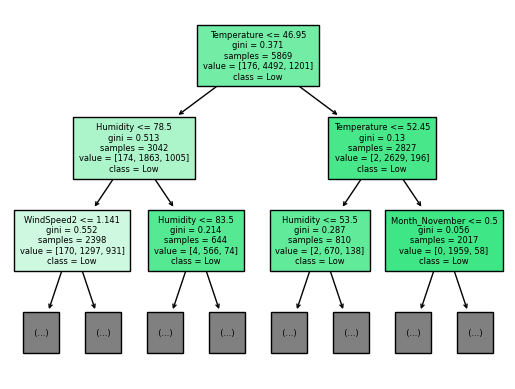

In [14]:
sklearn.tree.plot_tree(resultsTree, feature_names = list(features), filled = True,\
                       class_names = modelTree.classes_, max_depth = 2, fontsize = 6)

As with the Random Forest model predicting PotholeReports, we have another example of overfitting where the model fits the Training data perfectly (100% accuracy), but only has a 72% accuracy on the Test data. Part of the issue is with the lower count of observations in the Medium and High categories. Looking at the F1 scores for the Test data, the accuracy is 84% for the Low Expected Workload category, but only 36% for Medium and 16% for High.